# Exercise 2: Investigate model performance bottlenecks with PyTorch Profiler

You have explored hardware platforms, performance metrics, and hardware-first thinking in theory. It is now time to move from understanding concepts to hands-on diagnosis, and systematically investigate real model performance bottlenecks using professional profiling tools.

> **Overview:** A fintech company's customer churn prediction model (a multi-layer perceptron processing transaction features) is causing API timeouts in production. Use PyTorch Profiler's multiple analysis modes to diagnose performance issues and identify optimization opportunities on your GPU.
> 
> **Scenario:** You work for a fintech startup that predicts customer churn to trigger retention campaigns. Your ML team deployed a neural network that processes customer transaction features to predict churn probability. In development on your local machine, individual predictions ran smoothly, but when deployed to production with realistic API loads and batch processing, your DevOps team reports inconsistent performance that's causing service level agreement violations.
> 
> Your DevOps team reports the production servers use NVIDIA T4 GPUs (same as your development environment), but something about the production workload is causing severe performance degradation. You need to systematically profile the model to identify what's limiting throughput and causing the performance variability.
> 
> **Goal**: Learn to use PyTorch Profiler's timeline analysis, memory profiling, and GPU utilization monitoring to systematically diagnose performance bottlenecks and identify hardware-specific optimization opportunities in production AI deployments.
> 
> **Tools**: PyTorch, PyTorch Profiler, pynvml, pandas
> 
> **Estimated Time**: 15 minutes

## Step 1: Setup

Let's start by setting up our profiling environment.

In [1]:
# # Uncomment to install necessary libraries, then comment out the cell block again and restart the notebook
# # ! pip install pynvml kagglehub

In [2]:
# Import core libraries
import os
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.profiler
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import pynvml
import time
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory
output_dir = "assets/exercise2"
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Initialize NVIDIA management library
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

# Check GPU availability and get T4 info
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Using GPU: {gpu_name}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("CUDA not available, using CPU")

print("Setup complete!")

Using GPU: Tesla T4
CUDA Version: 12.1
GPU Memory: 15.6 GB
Setup complete!


## Step 2. Load the dataset

For this exercise, we use the [Telco Customer Churn dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn), hosted in Kaggle.
The raw data contains 7043 rows (customers) and 21 columns (features).

In [4]:
# Download the dataset
df_name = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
df_dirpath = kagglehub.dataset_download("blastchar/telco-customer-churn")
df_path = os.path.join(df_dirpath, df_name)
print("Path to dataset files:", df_path)

Path to dataset files: /home/student/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [5]:
# Load the dataset
df = pd.read_csv(df_path)

# Get dataset info
print(f"Dataset colums: {list(df.columns)}")
print(df.info)

Dataset colums: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
<bound method DataFrame.info of       customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72  

In [6]:
# Preprocess dataset
# Data preprocessing for the real dataset
print("\nPreprocessing the dataset...")

# Handle TotalCharges column (contains some string values that need conversion)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Encode categorical variables
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                      'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                      'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                      'PaperlessBilling', 'PaymentMethod']

# Use LabelEncoder for binary categorical variables and get_dummies for multi-class
label_encoders = {}
for col in categorical_columns:
    if df[col].nunique() == 2 or (df[col].nunique() == 3 and 'No phone service' in df[col].values):
        # Binary encoding for simple categorical variables
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    else:
        # One-hot encoding for multi-class variables
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop customerID as it's just an identifier
df.drop('customerID', axis=1, inplace=True)

# Prepare features and target
feature_columns = [col for col in df.columns if col != 'Churn']
X = df[feature_columns].values
y = df['Churn'].values

print(f"\nFinal dataset info:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Churn rate: {y.mean():.1%}")
print(f"Number of features after encoding: {len(feature_columns)}")

# Display first few feature names for reference
print(f"\nFeature Columns: {feature_columns}")


Preprocessing the dataset...

Final dataset info:
Features shape: (7043, 38)
Target shape: (7043,)
Churn rate: 26.5%
Number of features after encoding: 38

Feature Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Cr

> **Dataset insights**: The Telco dataset contains 7,043 customers with 21 features covering demographics, services, and billing information. 
> 
> After preprocessing categorical variables (gender, contract types, internet services, etc.), we end up with 38 features given one-hot encoding. 
> 
> The 26.5% churn rate provides a realistic class imbalance that mirrors production scenarios. 

In [7]:
# Prepare features and target
label_col = 'Churn'
feature_columns = [col for col in df.columns if col != label_col]
X = df[feature_columns].values
y = df[label_col].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print(f"Training data shape: {X_train_tensor.shape}")
print(f"Test data shape: {X_test_tensor.shape}")

Training data shape: torch.Size([5634, 38])
Test data shape: torch.Size([1409, 38])


## Step 3: Create the "problematic" model architecture
Let's create a neural network with intentional inefficiencies that mirror common real-world performance issues.

In [8]:
class ProblematicChurnModel(nn.Module):
    """
    A deliberately inefficient model architecture that creates realistic bottlenecks
    on T4 GPUs. This simulates common mistakes in production deployments.
    """
    def __init__(self, input_size, hidden_sizes=[512, 1024, 512, 256, 128]):
        super(ProblematicChurnModel, self).__init__()
        
        # Inefficient architecture choices that will show up in profiling:
        
        # 1. Oversized hidden layers for the problem complexity
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            # 2. Using individual Linear layers instead of Sequential blocks
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            # 3. Inefficient dropout placement (will cause extra memory operations)
            layers.append(nn.Dropout(0.3))
            prev_size = hidden_size
        
        # 4. Output layer
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
        
        # 5. Inefficient custom forward pass that will show up in profiling
        self.custom_activation = nn.ReLU()
        
    def forward(self, x):
        # 6. Inefficient forward pass with unnecessary operations
        # This creates CPU-GPU synchronization points
        batch_size = x.size(0)
        
        # Extra tensor operations that fragment GPU utilization
        x = x + 0.0001  # Unnecessary operation that creates new tensor
        x = x * 1.0001  # Another unnecessary operation
        
        # Pass through main network
        x = self.network(x)
        
        # 7. Inefficient final processing
        # Force CPU-GPU sync (performance killer!)
        if batch_size > 1:
            # This creates a synchronization point
            mean_activation = torch.mean(x).item()  # .item() forces sync!
            
        return x

# TODO: Create the model on GPU
# Hint: Review https://discuss.pytorch.org/t/is-there-any-difference-between-x-to-cuda-vs-x-cuda-which-one-should-i-use/20137
# for information on how to move a model to cuda
model = ProblematicChurnModel(input_size=len(feature_columns)).to(device)  # Add your code here

print("Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
ProblematicChurnModel(
  (network): Sequential(
    (0): Linear(in_features=38, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=128, out_features=1, bias=True)
    (16): Sigmoid()
  )
  (custom_activation): ReLU()
)

Total parameters: 1,234,433


> **Architecture analysis**: Notice the deliberately problematic choices:
> 
> - Oversized layers (1024 units for simple tabular data)
> - Inefficient forward pass with unnecessary tensor operations
> - CPU-GPU synchronization points that will show up clearly in profiling
> - Dropout in inference mode (though PyTorch optimizes this out)

## Step 4: Establish baseline model performance

Let's train now our baseline model to measure baseline performance.

In [9]:
# Train the problematic model
print("Training the problematic model...")

# Setup training
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop (keep it short for the exercise)
model.train()
for epoch in range(5):  # Quick training, just enough to get reasonable weights
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 2 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/5, Average Loss: {avg_loss:.4f}")

print("Training complete!")

Training the problematic model...
Epoch 1/5, Average Loss: 0.4680
Epoch 3/5, Average Loss: 0.4257
Epoch 5/5, Average Loss: 0.4274
Training complete!


> **Note on model accuracy**: Since this exercise focuses on performance profiling, we skip evaluating model accuracy. Our goal is to diagnose why that model runs slowly during inference, regardless of how well it predicts churn.
> 
> In production, you'd have a well-trained model that meets your accuracy requirements. Feel free to extend this exercise by adding validation accuracy tracking, confusion matrix analysis, or ROC curve evaluation if you want to explore the trade-offs between model performance optimization and predictive accuracy!

In [10]:
## Create DataLoaders with different batch sizes to simulate production scenarios
batch_sizes = [32, 64, 128, 512, 1024]  # We'll test different batch sizes
dataloaders = {}

for batch_size in batch_sizes:
    dataset = TensorDataset(X_test_tensor, y_test_tensor)
    dataloaders[batch_size] = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
print(f"Created DataLoaders for batch sizes: {batch_sizes}")

Created DataLoaders for batch sizes: [32, 64, 128, 512, 1024]


In [11]:
# Measure baseline performance without profiling
def measure_baseline_performance(model, dataloader, num_batches=10):
    """Measure baseline inference performance"""
    
        
    model.eval()
    times = []

    # TODO: Measure inference times on first few batches
    # Hint: Use torch.cuda.synchronize() before and after inference, then measure time with time.perf_counter()
    # Don't forget to break the loop after num_batches has been achieved

    # Add your code here
    
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            if i >= num_batches:  # Only measure first few batches
                break
                
            torch.cuda.synchronize()  # Ensure previous operations complete
            start_time = time.perf_counter()
            
            outputs = model(inputs)
            
            torch.cuda.synchronize()  # Ensure inference completes
            end_time = time.perf_counter()
            
            times.append(end_time - start_time)
    
    return times

## Start measurement wifferent batch sizes
baseline_results = {}
print("Measuring baseline performance...")

for batch_size in batch_sizes:
    times = measure_baseline_performance(model, dataloaders[batch_size])
    avg_time = np.mean(times) * 1000  # Convert to milliseconds
    baseline_results[batch_size] = {
        'avg_time_ms': avg_time,
        'std_time_ms': np.std(times) * 1000,
        'times': times
    }
    print(f"Batch size {batch_size}: {avg_time:.2f} ± {baseline_results[batch_size]['std_time_ms']:.2f} ms")

baseline_results = {}

Measuring baseline performance...
Batch size 32: 1.43 ± 0.28 ms
Batch size 64: 1.33 ± 0.12 ms
Batch size 128: 1.11 ± 0.28 ms
Batch size 512: 1.18 ± 0.22 ms
Batch size 1024: 1.44 ± 0.50 ms


> **Batch size optimization insight**: Notice that it is not the larger batch size to achieve better performance This is because:
> 
> - **With too small batches**: GPU cores underutilized, overhead from frequent kernel launches
> - **With optimal batch**: Good GPU utilization without memory pressure 
> - **With too large batches**: Memory bandwidth saturation and increased variance
> 
> This "sweet spot" pattern is common in production - optimal batch size balances GPU utilization with memory efficiency.

## Step 5: GPU system monitoring with pynvml
Before diving into detailed profiling, let's establish our hardware baseline using NVIDIA's system monitoring.

In [12]:
# Create functions to monitor GPU utilization and memory usage

def get_gpu_stats():
    """Get current GPU utilization and memory usage"""
    # TODO: Get utilization rates (GPU and memory) using pynvml
    # Hint: Find a complete list of methods at https://docs.nvidia.com/deploy/nvml-api/nvml-api-reference.html
    # You can use the `handle` previously created
    util = pynvml.nvmlDeviceGetUtilizationRates(handle)  # Add your code here
    memory = pynvml.nvmlDeviceGetMemoryInfo(handle)  # Add your code here
    temp = pynvml.nvmlDeviceGetTemperature(handle, pynvml.NVML_TEMPERATURE_GPU)  # Add your code here
    power_usage = pynvml.nvmlDeviceGetPowerUsage(handle) / 1000.0  # Add your code here
    power_limit = pynvml.nvmlDeviceGetPowerManagementLimitConstraints(handle)[1] / 1000.0  # Add your code here
    graphics_clock = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_GRAPHICS)  # Add your code here
    memory_clock = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_MEM)  # Add your code here
    perf_state = pynvml.nvmlDeviceGetPerformanceState(handle)  # Add your code here
    throttle_reasons = pynvml.nvmlDeviceGetCurrentClocksThrottleReasons(handle)  # Add your code here
    
    return {
        # Basic utilization
        'gpu_util': util.gpu,
        'memory_util': util.memory,
        'memory_used_mb': memory.used / 1024**2,
        'memory_total_mb': memory.total / 1024**2,
        'memory_free_mb': memory.free / 1024**2,
        
        # Thermal and power
        'temperature_c': temp,
        'power_usage_w': power_usage,
        'power_limit_w': power_limit,
        'power_efficiency': util.gpu / max(power_usage, 1),  # GPU util per watt
        
        # Performance monitoring
        'graphics_clock_mhz': graphics_clock,
        'memory_clock_mhz': memory_clock,
        'performance_state': perf_state,
        'is_throttling': throttle_reasons != 0,
        'throttle_reasons': throttle_reasons
    }


def monitor_inference_workload(model, dataloader, duration_seconds=10):
    """Monitor GPU stats during inference workload"""
    model.eval()
    stats_history = []

    # Add debugging to ensure we're actually using GPU
    print(f"Model device: {next(model.parameters()).device}")
    print(f"Input data will be on: {device}")
    
    start_time = time.time()
    batch_count = 0
    
    with torch.no_grad():
        while time.time() - start_time < duration_seconds:
            for inputs, _ in dataloader:
                # Record stats before inference
                stats_before = get_gpu_stats()
                
                # TODO: Run inference
                # Hint: Remember to synchronize, and add a small delay to ensure GPU work is captured

                # Add your code here
                torch.cuda.synchronize() 
                outputs = model(inputs)
                torch.cuda.synchronize()
                
                # Record stats after inference
                stats_after = get_gpu_stats()
                
                stats_history.append({
                    'batch': batch_count,
                    'timestamp': time.time() - start_time,     
                    'batch_size': inputs.shape[0],

                    # Before inference
                    'gpu_util_before': stats_before['gpu_util'],
                    'memory_used_before_mb': stats_before['memory_used_mb'],
                    'temp_before_c': stats_before['temperature_c'],
                    'power_before_w': stats_before['power_usage_w'],
                    
                    # After inference  
                    'gpu_util_after': stats_after['gpu_util'],
                    'memory_used_after_mb': stats_after['memory_used_mb'],
                    'temp_after_c': stats_after['temperature_c'],
                    'power_after_w': stats_after['power_usage_w'],
                    
                    # Derived metrics
                    'gpu_util_delta': stats_after['gpu_util'] - stats_before['gpu_util'],
                    'memory_delta_mb': stats_after['memory_used_mb'] - stats_before['memory_used_mb'],
                    'temp_delta_c': stats_after['temperature_c'] - stats_before['temperature_c'],
                    'power_delta_w': stats_after['power_usage_w'] - stats_before['power_usage_w'],
                    
                    # Hardware state
                    'is_throttling': stats_after['is_throttling'],
                    'performance_state': stats_after['performance_state']
                })
                
                batch_count += 1
                
                if time.time() - start_time >= duration_seconds:
                    break
    
    return stats_history

# Run monitoring for batch size 64 and analyze the results
print("Monitoring GPU utilization during inference...")
stats = monitor_inference_workload(model, dataloaders[512], duration_seconds=8)

# Analyze the monitoring results
gpu_utils_after = [s['gpu_util_after'] for s in stats]  
temps_after = [s['temp_after_c'] for s in stats]
power_usage_after = [s['power_after_w'] for s in stats]
memory_usage_after = [s['memory_used_after_mb'] for s in stats]
throttling_events = [s for s in stats if s['is_throttling']]

# Calculate power efficiency
power_efficiency = [gpu_util / max(power, 1) for gpu_util, power in zip(gpu_utils_after, power_usage_after)]

print(f"\n=== COMPREHENSIVE GPU ANALYSIS ===")
print(f"Average GPU utilization: {np.mean(gpu_utils_after):.1f}%")
print(f"Peak GPU utilization: {np.max(gpu_utils_after):.1f}%")
print(f"GPU utilization std dev: {np.std(gpu_utils_after):.1f}%")
print(f"Temperature range: {np.min(temps_after):.1f}°C - {np.max(temps_after):.1f}°C")
print(f"Power usage range: {np.min(power_usage_after):.1f}W - {np.max(power_usage_after):.1f}W")
print(f"Average power efficiency: {np.mean(power_efficiency):.2f} util%/W")
print(f"Average memory usage: {np.mean(memory_usage_after):.1f} MB")
print(f"Performance state (P0=max): P{stats[0]['performance_state']}")

if throttling_events:
    print(f"WARNING:  THROTTLING DETECTED: {len(throttling_events)} events out of {len(stats)} batches")
    print("   This could explain performance degradation!")
else:
    print("SUCCESS: No throttling detected during monitoring period")

# Analyze the before/after patterns  
gpu_util_deltas = [s['gpu_util_delta'] for s in stats]
memory_deltas = [s['memory_delta_mb'] for s in stats]
temp_deltas = [s['temp_delta_c'] for s in stats]
power_deltas = [s['power_delta_w'] for s in stats]

print(f"\n=== INFERENCE IMPACT ANALYSIS ===")
print(f"GPU utilization change per batch: {np.mean(gpu_util_deltas):.1f}% ± {np.std(gpu_util_deltas):.1f}%")
print(f"Memory allocation per batch: {np.mean(memory_deltas):.2f} MB ± {np.std(memory_deltas):.2f} MB")
print(f"Temperature increase per batch: {np.mean(temp_deltas):.2f}°C ± {np.std(temp_deltas):.2f}°C") 
print(f"Power consumption change: {np.mean(power_deltas):.1f}W ± {np.std(power_deltas):.1f}W")

print(f"\nProcessed {len(stats)} batches with comprehensive hardware monitoring")

Monitoring GPU utilization during inference...
Model device: cuda:0
Input data will be on: cuda

=== COMPREHENSIVE GPU ANALYSIS ===
Average GPU utilization: 0.5%
Peak GPU utilization: 7.0%
GPU utilization std dev: 0.8%
Temperature range: 35.0°C - 38.0°C
Power usage range: 25.5W - 36.9W
Average power efficiency: 0.02 util%/W
Average memory usage: 647.2 MB
Performance state (P0=max): P0
SUCCESS: No throttling detected during monitoring period

=== INFERENCE IMPACT ANALYSIS ===
GPU utilization change per batch: 0.1% ± 0.3%
Memory allocation per batch: 0.00 MB ± 0.00 MB
Temperature increase per batch: 0.03°C ± 0.25°C
Power consumption change: 0.0W ± 0.7W

Processed 127 batches with comprehensive hardware monitoring


> TODO: Analyze GPU monitoring insights and identify potential issues
> 
> Hint: Focus on GPU utilization patterns and power efficiency metrics. What does extremely low GPU utilization tell you about how the model is using the T4's parallel processing capabilities?

**Critical issue: Severe GPU under-utilization detected!**

- **GPU Utilization**: 0.5% average (7.0% peak) - **2,560 CUDA cores sitting 99.5% idle!**
- **Hardware waste**: T4 GPU designed for 16 TeraFLOPS, but we're achieving <1% of capability
- **Power Efficiency**: 0.02 util%/W - GPU consuming 30W but doing minimal work
- **Memory Usage**: 647MB (~4% of T4's 16GB) - massive memory bandwidth wasted
- **Hardware Health**: No thermal issues (35-38°C), no throttling, P0 performance state

**Root cause analysis**: The model is not leveraging GPU parallelism effectively. With 2,560 CUDA cores idle, the bottleneck is clearly not computational capacity - it's how we're feeding work to the GPU.

**Primary optimization target**: Focus on increasing GPU utilization rather than thermal/power management. This suggests data pipeline inefficiencies or CPU-GPU synchronization issues rather than hardware constraints.

## Step 6: Deep profiling with PyTorch Profiler
Now let's use PyTorch Profiler to understand what's happening at the kernel level.


In [13]:
def profile_model_performance(model, dataloader, batch_size, num_batches=5):
    """Profile model with PyTorch Profiler"""
    model.eval()
    
    # TODO: Configure profiler settings as a reusable configuration dictionary
    # Hint: Create profiler_config dict with activities, record_shapes, profile_memory, etc.
    # Documentation: https://pytorch.org/docs/stable/profiler.html#torch.profiler.profile
    profiler_config = {
        'activities': [
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        'record_shapes': True,    # Record tensor shapes
        'profile_memory': True,   # Profile memory usage
        'with_stack': True,       # Include call stack info
        'with_flops': True,       # Include FLOP counts
    }  # Add your code here
    
    with torch.profiler.profile(**profiler_config) as prof:
    
        with torch.no_grad():
            for i, (inputs, _) in enumerate(dataloader):
                if i >= num_batches:
                    break
                
                # TODO: Run model inference with profiling
                # Hint: How does the profiler know that the next iteration has started?
                # Documentation: https://pytorch.org/docs/stable/profiler.html#torch.profiler.profile

                # Add your code here
                
                prof.step()
                outputs = model(inputs)
    
    return prof

# Profile the model with batch size 64
print("Starting detailed profiling...")
profiler_result = profile_model_performance(model, dataloaders[512], batch_size=64)

print("Profiling complete!")

Starting detailed profiling...


STAGE:2025-08-05 15:03:25 10729:10729 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-08-05 15:03:25 10729:10729 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-08-05 15:03:25 10729:10729 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Profiling complete!


In [14]:
# Analyze profiling results

print("=== TOP 10 MOST TIME-CONSUMING OPERATIONS ===")
# TODO: Display operations that take the most total time on the GPU
# Hint: Consider grouping operations based on how they're called, and look for a method to summarize and rank them by total GPU time.
# The profiler has an API for generating a table of summarized events: https://pytorch.org/docs/stable/profiler.html
top_ops = profiler_result.key_averages(group_by_input_shape=True).table(
    sort_by="cuda_time_total", row_limit=10
)  # Add your code here
print(top_ops)

print("\n=== MEMORY-INTENSIVE OPERATIONS ===")
# TODO: Highlight operations responsible for the most GPU memory usage
# Hint: Focus on identifying which operations allocate the most memory directly (not cumulative usage).
# There's a metric related to "self" memory usage that can help isolate expensive memory allocators: https://pytorch.org/docs/stable/profiler.html
memory_ops = profiler_result.key_averages().table(
    sort_by="self_cuda_memory_usage", row_limit=8
)  # Add your code here
print(memory_ops)

print("\n=== CPU vs CUDA TIME ANALYSIS ===")
# TODO: Identify operations with large discrepancies between CPU and GPU execution time
# Hint: Look for signs of CPU-GPU synchronization delays; these usually appear when CPU time dominates.
# Try sorting by total CPU time and observe the ratio of CPU to CUDA time for each operation: https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html
cpu_analysis = profiler_result.key_averages().table(
    sort_by="cpu_time_total", row_limit=10
)  # Add your code here
print(cpu_analysis)

print("\n=== OPERATION CALL FREQUENCY ANALYSIS ===")
# TODO: Detect frequently called operations with minimal per-call overhead
# Hint: Sorting by how often operations are called can uncover inefficiencies in batching or kernel launches.
# High frequency + low time per call = potential optimization opportunity: https://pytorch.org/docs/stable/profiler.html
frequency_analysis = profiler_result.key_averages().table(
    sort_by="count", row_limit=12
)  # Add your code here
print(frequency_analysis)


=== TOP 10 MOST TIME-CONSUMING OPERATIONS ===
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls                                   Input Shapes  Total KFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------  ------------  
enumera

> TODO: Extract key performance insights from PyTorch profiler output
> 
> Hint: Focus on identifying CPU-GPU synchronization issues (high CPU time + low CUDA time) and kernel launch overhead (many small operations).
> 
> Find inspiration at https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html#analyzing-performance

**PyTorch Profiler analysis results**

- **Primary bottlenecks identified:**

   1. **CPU-GPU synchronization issues**
      - DataLoader operations: 56.35% CPU time, 0% CUDA utilization
      - Tensor reshaping dominates: `aten::select` (19.94% CPU), `aten::unsqueeze` (4.92% CPU)
      - **Root cause**: Model spending more time moving/reshaping data than computing
   <br><br>
   2. **Kernel launch overhead** 
      - 4,251 `aten::as_strided` calls (0.140μs each)
      - 2,818 `aten::select` calls (3.296μs each)  
      - **Impact**: Thousands of tiny operations overwhelming GPU scheduling
   <br><br>
   3. **Compute vs overhead imbalance**
      - Actual ML computation (`aten::addmm`): Only 2.25% CPU time
      - Tensor manipulation overhead: >75% of total execution time
      - **Result**: GPU sitting idle while CPU handles data preprocessing
   <br><br>
- **Optimization priorities:**
   1. **Eliminate DataLoader synchronization** points causing 56% CPU overhead
   2. **Batch tensor operations** to reduce 4,000+ individual kernel launches  
   3. **Optimize data pipeline** to move reshaping operations off critical path
   <br><br>
- **Hardware utilization**: Profiler confirms <1% GPU utilization from Step 4 - model is CPU-bound due to excessive tensor manipulation, not compute-bound.

- **Key learning**: While we expected architectural issues (with oversized layers, CPU-GPU sync from .item() calls), we found data loading and preprocessing dominating execution. The "slow model" problem was actually a "slow data pipeline" problem. This is extremely common in production. In practice, this means that the expensive GPU sits idle while the CPU struggles to prepare the next batch of data leading to 10x longer inference times!

### Step 6.5: Profile layer-by-layer model performance

While Step 6 revealed data loading as our primary bottleneck, we should also understand how our individual model layers perform on GPU. Even though the model represents only ~3% of execution time, layer-level analysis helps identify which architectural components are GPU-efficient versus CPU-bound, providing our optimization priorities once we fix the data pipeline.

In [16]:
# Analyze performance by model layer
def analyze_model_layers(profiler_result):
    """Break down performance by individual model layers"""
    
    # TODO: Extract only layer-specific operations from profiler results
    # Hint: Filter profiler_result's events 'for events containing layer names like 'linear', 'relu', ...
    layer_events = [event for event in profiler_result.key_averages() 
                   if any(layer_name in event.key.lower() 
                         for layer_name in ['linear', 'relu', 'dropout', 'sigmoid'])]  # Add your code here
    
    print("=== LAYER-BY-LAYER PERFORMANCE BREAKDOWN ===")
    layer_analysis = profiler_result.key_averages().table(
        sort_by="cuda_time_total", row_limit=15,
        header="Layer Performance Analysis"
    )
    print(layer_analysis)
    
    layer_groups = {}
    # TODO: Group layer events by operation type and calculate aggregate statistics
    # Hint: Create a dictionary where keys are layer types ('Linear Layers', 'ReLU Activations', etc.) 
    # and values contain summed `cuda_time``, `cpu_time``, `memory`` usage, and call `counts``

    # Add your code here
    for event in layer_events:
        if 'linear' in event.key.lower():
            layer_type = 'Linear Layers'
        elif 'relu' in event.key.lower():
            layer_type = 'ReLU Activations'  
        elif 'dropout' in event.key.lower():
            layer_type = 'Dropout Layers'
        elif 'sigmoid' in event.key.lower():
            layer_type = 'Sigmoid Output'
        else:
            layer_type = 'Other'
            
        if layer_type not in layer_groups:
            layer_groups[layer_type] = {'cuda_time': 0, 'cpu_time': 0, 'memory': 0, 'count': 0}
        
        layer_groups[layer_type]['cuda_time'] += event.cuda_time
        layer_groups[layer_type]['cpu_time'] += event.cpu_time  
        layer_groups[layer_type]['memory'] += event.self_cuda_memory_usage
        layer_groups[layer_type]['count'] += event.count

    return layer_groups

layer_breakdown = analyze_model_layers(profiler_result)

# Visualize layer contributions
print("\n=== MODEL LAYER EFFICIENCY ANALYSIS ===")
for layer_type, stats in layer_breakdown.items():
    cuda_ms = stats['cuda_time'] / 1000
    cpu_ms = stats['cpu_time'] / 1000
    memory_mb = stats['memory'] / (1024**2)
    efficiency_ratio = cuda_ms / max(cpu_ms, 0.001)
    
    print(f"{layer_type}:")
    print(f"  CUDA time: {cuda_ms:.2f}ms | CPU time: {cpu_ms:.2f}ms")
    print(f"  Memory usage: {memory_mb:.1f}MB | Calls: {stats['count']}")
    print(f"  Efficiency ratio (CUDA/CPU): {efficiency_ratio:.2f}")
    print()

=== LAYER-BY-LAYER PERFORMANCE BREAKDOWN ===
Layer Performance Analysis
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total KFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...         0.00%       0.000us         0.00%       0.000us       0.00

> TODO: Analyze layer-level performance insights and their impact on optimization strategy
> 
> Hint: Focus on GPU efficiency ratios for each layer type and the relationship between number of operations and kernel launch overhead. How does this change your understanding of the primary performance bottleneck identified in Step 5?

**Layer-by-layer performance analysis results**:
 
- *Architecture overkill confirmed*: 48 total layer operations (18 Linear + 15 ReLU + 15 Dropout) for simple tabular data represent massive over-engineering for 38 features → binary classification
- *Systemic GPU under-utilization*: Linear layers show only 0.44 CUDA/CPU efficiency ratio, activation functions even worse at 0.06-0.10 - every single layer is CPU-bottlenecked
- *Kernel launch overhead dominates*: 72 kernel launches consuming 670μs vs. 759μs actual computation time - spending 88% of time starting GPU work instead of doing GPU work

*Root cause*: The model architecture creates a "death by a thousand cuts": a layer operation requires separate GPU kernel launch, overwhelming the scheduler with tiny operations instead of leveraging GPU's parallel processing strength.
 
*Optimization priority*: Reduce architecture complexity (2-3 layers max) and fuse operations (Linear+ReLU) to minimize kernel launches and maximize GPU utilization per operation. 

*Expected impact*: The data pipeline stand as the primary bottleneck (56% of total time), but architecture optimization could unlock ~=2% time reduction by reducing the overhead created by kernel launches. By improving both data pipeline and architecture, we remove all pipeline inefficiencies.


## Bonus Step: Visualize timeline analysis
Let's create visualizations to understand the temporal behavior of our model.

=== TIMELINE ANALYSIS RESULTS ===
Chrome trace saved to: assets/exercise2/model_trace.json
Total CUDA time: 2.42 ms
Total CPU time: 12.38 ms
CUDA/CPU ratio: 0.20
Number of profiled events: 45


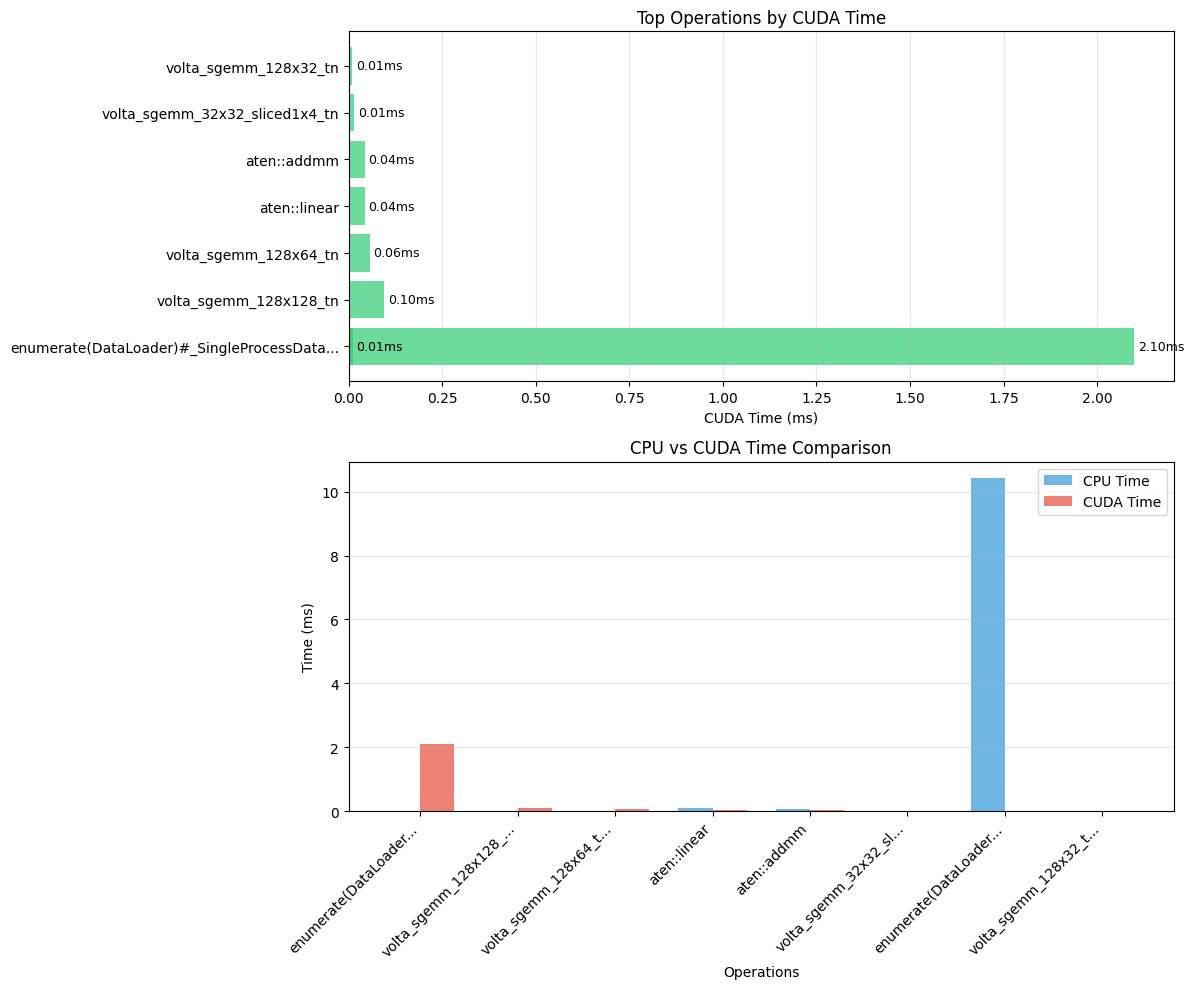

In [15]:
# Generate timeline trace for detailed temporal analysis
def generate_timeline_analysis(profiler_result, filename="model_trace"):
    """Generate timeline trace and basic analysis"""
    
    trace_file = os.path.join(output_dir, f"{filename}.json")
    # TODO: Export trace (can be viewed in chrome://tracing)
    # Hint: Look for exporting functions at https://docs.pytorch.org/docs/stable/profiler.html
    # And note that the export can be called only once for session
    
    # Add your code here
    if not os.path.exists(trace_file):
        profiler_result.export_chrome_trace(trace_file)
    
    # TODO: Get detailed event information
    # Hint: # Tip: Start exploring with .key_averages(), then add grouping arguments.
    events = profiler_result.key_averages(group_by_stack_n=5)  # Add your code here
    
    # TODO: Analyze GPU vs CPU time distribution
    # Hint: Each profiler event object contains both CPU and CUDA timing attributes.
    # Explore an event to find out all attributes
    total_cuda_time = sum([event.cuda_time for event in events])  # Add your code here
    total_cpu_time = sum([event.cpu_time for event in events])  # Add your code here
    
    timeline_stats = {
        'trace_file': trace_file,
        'total_cuda_time_ms': total_cuda_time / 1000,
        'total_cpu_time_ms': total_cpu_time / 1000,
        'cuda_cpu_ratio': total_cuda_time / max(total_cpu_time, 1),
        'num_events': len(events)
    }
    
    return timeline_stats, events

timeline_stats, detailed_events = generate_timeline_analysis(profiler_result)

print("=== TIMELINE ANALYSIS RESULTS ===")
print(f"Chrome trace saved to: {timeline_stats['trace_file']}")
print(f"Total CUDA time: {timeline_stats['total_cuda_time_ms']:.2f} ms")
print(f"Total CPU time: {timeline_stats['total_cpu_time_ms']:.2f} ms")
print(f"CUDA/CPU ratio: {timeline_stats['cuda_cpu_ratio']:.2f}")
print(f"Number of profiled events: {timeline_stats['num_events']}")

# Create visualization of the performance bottlenecks
def visualize_bottlenecks(events, top_n=8):
    """Create visualization of performance bottlenecks"""
    
    # TODO: Extract top_n operations by CUDA time, sort them, and extract relevant keys (names, cuda times in ms, and cpu times in ms)
    # Hint: The .cuda_time attribute (in microseconds) can help rank performance bottlenecks.
    # For the `names``, you may want to trim long operation names for better visualization.
    sorted_events = sorted(events, key=lambda x: x.cuda_time, reverse=True)[:top_n]  # Add your code here    
    names = [event.key[:40] + "..." if len(event.key) > 40 else event.key 
             for event in sorted_events]  # Add your code here
    cuda_times = [event.cuda_time / 1000 for event in sorted_events]   # Add your code here
    cpu_times = [event.cpu_time / 1000 for event in sorted_events]  # Add your code here
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # CUDA time breakdown
    bars1 = ax1.barh(names, cuda_times, color='#2ecc71', alpha=0.7)
    ax1.set_xlabel('CUDA Time (ms)')
    ax1.set_title('Top Operations by CUDA Time')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar, time_val in zip(bars1, cuda_times):
        ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{time_val:.2f}ms', va='center', fontsize=9)
    
    # CPU vs CUDA comparison
    x_pos = np.arange(len(names))
    width = 0.35
    
    bars2 = ax2.bar(x_pos - width/2, cpu_times, width, label='CPU Time', 
                    color='#3498db', alpha=0.7)
    bars3 = ax2.bar(x_pos + width/2, cuda_times, width, label='CUDA Time', 
                    color='#e74c3c', alpha=0.7)
    
    ax2.set_xlabel('Operations')
    ax2.set_ylabel('Time (ms)')
    ax2.set_title('CPU vs CUDA Time Comparison')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([name[:20] + "..." if len(name) > 20 else name 
                        for name in names], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'performance_bottlenecks.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return sorted_events

top_bottlenecks = visualize_bottlenecks(detailed_events)

> **Timeline visualization**: You can open the generated Chrome trace file in Chrome browser by navigating to chrome://tracing and loading the JSON file for detailed timeline analysis. This gives a detailed, interactive timeline of CPU and GPU activities, helping you pinpoint performance bottlenecks like synchronization delays, long-running ops, or kernel launch gaps.
>
> And, it's also a great artifact to share with your team when reviewing model performance!

## Conclusion

In this exercise, you've learned how to diagnose and optimize AI model performance using a systematic, multi-layered profiling approach. Specifically, you have explored how to:

- **Use PyTorch Profiler to identify performance bottlenecks** at both system and operation levels
- **Monitor GPU utilization with pynvml** to understand hardware resource usage and detect under-utilization patterns
- **Analyze timeline data** to find CPU-GPU synchronization issues and kernel launch overhead
- **Conduct layer-by-layer performance analysis** to identify architectural inefficiencies within model execution
- **Prioritize compound optimization opportunities** by distinguishing between macro-level (system) and micro-level (model) bottlenecks
- **Apply systematic performance measurement** to validate which optimizations deliver the greatest impact


These profiling skills directly translate to production scenarios where models perform differently than expected. **The key insight**: production performance problems are often compound issues requiring multiple optimization strategies, with clear prioritization based on profiling evidence rather than assumptions.

The next time your model is slower than expected in production, you'll know exactly how to systematically diagnose both system-level and model-level inefficiencies, then prioritize fixes based on actual performance impact!

**Bonus exploration ideas**:

- Mixed precision profiling: Enable automatic mixed precision (AMP) and profile the performance/memory improvements
- Memory timeline exploration: Use [`export_memory_timeline()`](https://docs.pytorch.org/docs/stable/profiler.html#torch.profiler._KinetoProfile.export_memory_timeline) to spot fragmentation or memory leaks.
- Batch size optimization: Find the optimal batch size for your specific model architecture